In [1]:
import sys

sys.path.append("ares_transverse_tuning")

In [2]:
import time
from datetime import datetime
from pathlib import Path

import gymnasium as gym
import langchain
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from dotenv import load_dotenv
from gymnasium.wrappers import TimeLimit
from icecream import ic
from langchain.callbacks import FileCallbackHandler, wandb_tracing_enabled
from langchain.chains import LLMChain
from langchain.chat_models import ChatOllama
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from loguru import logger
from openai import RateLimitError
from src.environments.ea import TransverseTuning
from src.eval import Episode
from src.trial import load_trials
from src.wrappers import RecordEpisode, TQDMWrapper

from pacuna import PACuna

In [3]:
load_dotenv()

plt.style.use(["science", "nature", "no-latex"])

langchain.debug = True

In [4]:
# chat_model = ChatOpenAI(model="gpt-3.5-turbo-0125")
# chat_model = ChatOpenAI(model="gpt-4")
# chat_model = ChatOpenAI(model="gpt-4-32k")
# chat_model = ChatOpenAI(model="gpt-4-0125-preview")
# chat_model = ChatOllama(model="mistral:v0.2", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="zephyr", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="mixtral:8x7b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="gemma:2b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="gemma:7b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="starling-lm:7b-beta", base_url="http://max-wng060:11434")
chat_model = ChatOllama(model="vicuna:7b-16k", base_url="http://max-wng058:11434")
# chat_model = ChatOllama(model="vicuna:33b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="llava:34b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="orca2:7b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="orca2:13b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="llama2:7b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="llama2:13b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="llama2:70b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="falcon:180b-chat", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="neural-chat:7b")
# chat_model = ChatOllama(model="mistral-openorca:7b", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="phi:chat")
# chat_model = ChatOllama(model="megadolphin:120b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="yi:34b-chat", base_url="http://max-wng054:11434") x
# chat_model = PACuna()

In [5]:
# chat_model.invoke("Hello")

In [6]:
TRIAL_INDEX = 38
trials = load_trials(Path("ares_transverse_tuning/data/trials.yaml"))
trial = trials[TRIAL_INDEX]
trial

Trial(target_beam=array([-0.00061349,  0.00026242,  0.00102625,  0.0003465 ]), incoming_beam=array([ 1.31279831e+08, -7.41156109e-04, -5.82922221e-05,  1.30710745e-04,
       -7.66231824e-06,  3.57008132e-04,  4.35580478e-05,  2.26216856e-04,
        1.96636520e-05,  1.79446160e-05,  2.96076818e-04]), misalignments=array([ 8.31616237e-05,  1.81952708e-04, -3.13049472e-04,  2.17823154e-04,
       -8.04967923e-05,  2.33286971e-04,  1.15469446e-04, -1.41215460e-04]), initial_magnets=array([ 1.06084118e+01, -1.92286568e+01,  2.02686829e-03,  8.72032261e+00,
       -5.51228318e-03]))

In [7]:
model_name = (
    chat_model.model_name if hasattr(chat_model, "model_name") else chat_model.model
).replace(":", "-")
now = datetime.now()

log_dir = (
    Path("data")
    / "paper"
    / "optimisation"
    / model_name
    / f"trial-{TRIAL_INDEX}_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
)
langchain_log_file = log_dir / "langchain.log"
logger.add(langchain_log_file, colorize=True, enqueue=True)
handler = FileCallbackHandler(langchain_log_file)

In [8]:
log_dir

PosixPath('data/paper/optimisation/vicuna-7b-16k/trial-38_2024-04-11_10-57-12')

In [9]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
# env = TimeLimit(env, max_episode_steps=18)
# env = RecordEpisode(env, Path("data/recorded_episodes"))
# env = TQDMWrapper(env)
env

In [10]:
observation, info = env.reset()
np.mean(np.abs(observation["target"] - observation["beam"])) * 1e3

0.7597511867061257

In [11]:
sample_template = """Inputs:
```json
{{
	"Q1": {q1:.2f},
	"Q2": {q2:.2f},
	"CV": {cv:.2f},
	"Q3": {q3:.2f},
	"CH": {ch:.2f}
}}
```
Objective value = {objective:.2f}
"""

In [12]:
message_template = """Now you will help me minimise a function with five input variables Q1, Q2, CV, Q3 and CH. I have some (Q1, Q2, CV, Q3, CH) pairs and the corresponding function values at those points. The samples are arranged in descending order based on their function values, where lower values are better.

{prior_samples}

Give me a new sample (Q1, Q2, CV, Q3, CH) that is different from all pairs above, and has a function value lower than any of the above.

{format_instructions}
"""

In [13]:
response_q1 = ResponseSchema(
    name="Q1",
    type="float",
    description="First input",
)
response_q2 = ResponseSchema(
    name="Q2",
    type="float",
    description="Second input",
)
response_cv = ResponseSchema(
    name="CV",
    type="float",
    description="Third input",
)
response_q3 = ResponseSchema(
    name="Q3",
    type="float",
    description="Fourth input",
)
response_ch = ResponseSchema(
    name="CH",
    type="float",
    description="Fifth input",
)

output_parser = StructuredOutputParser.from_response_schemas(
    [response_q1, response_q2, response_cv, response_q3, response_ch]
)

print(output_parser.get_format_instructions())

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Q1": float  // First input
	"Q2": float  // Second input
	"CV": float  // Third input
	"Q3": float  // Fourth input
	"CH": float  // Fifth input
}
```


In [14]:
prompt = PromptTemplate.from_template(message_template)
prompt

PromptTemplate(input_variables=['format_instructions', 'prior_samples'], template='Now you will help me minimise a function with five input variables Q1, Q2, CV, Q3 and CH. I have some (Q1, Q2, CV, Q3, CH) pairs and the corresponding function values at those points. The samples are arranged in descending order based on their function values, where lower values are better.\n\n{prior_samples}\n\nGive me a new sample (Q1, Q2, CV, Q3, CH) that is different from all pairs above, and has a function value lower than any of the above.\n\n{format_instructions}\n')

In [15]:
chain = LLMChain(
    prompt=prompt, llm=chat_model, output_parser=output_parser, callbacks=[handler]
)
decapitated_chain = LLMChain(prompt=prompt, llm=chat_model)
chain

LLMChain(callbacks=[<langchain.callbacks.file.FileCallbackHandler object at 0x10902b940>], prompt=PromptTemplate(input_variables=['format_instructions', 'prior_samples'], template='Now you will help me minimise a function with five input variables Q1, Q2, CV, Q3 and CH. I have some (Q1, Q2, CV, Q3, CH) pairs and the corresponding function values at those points. The samples are arranged in descending order based on their function values, where lower values are better.\n\n{prior_samples}\n\nGive me a new sample (Q1, Q2, CV, Q3, CH) that is different from all pairs above, and has a function value lower than any of the above.\n\n{format_instructions}\n'), llm=ChatOllama(base_url='http://max-wng058:11434', model='vicuna:7b-16k'), output_parser=StructuredOutputParser(response_schemas=[ResponseSchema(name='Q1', description='First input', type='float'), ResponseSchema(name='Q2', description='Second input', type='float'), ResponseSchema(name='CV', description='Third input', type='float'), Resp

In [16]:
# # with wandb_tracing_enabled():
# response = decapitated_chain.invoke(
#     {
#         "prior_samples": samples_str,
#         "format_instructions": output_parser.get_format_instructions(),
#     }
# )
# print(response["text"])

In [17]:
# with wandb_tracing_enabled():
#     response = chain.invoke(
#         {
#             "prior_samples": samples_str,
#             "format_instructions": output_parser.get_format_instructions(),
#         }
#     )
# print(response["text"])

In [18]:
class LLMTransverseTuningAgent:
    """
    An agent for doing transverse beam parameter tuning in the ARES experimental
    area using an LLM via LangChain.
    """

    #     message_template = """Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.
    #
    # The target beam parameters I want you to find are:
    #  - horizontal position: 0.0 μm
    #  - horizontal size: 0.0 μm
    #  - vertical position: 0.0 μm
    #  - vertical size: 0.0 μm
    #
    # You are able to control five magnets in the beam line. The magnets are called:
    #  - Q1
    #  - Q2
    #  - CV
    #  - Q3
    #  - CH
    #
    # Q1, Q2, Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.
    #
    # CV is vertical steering magnet. When its deflection angle is increased, the beam is steered upwards. When its deflection angle is decreased, the beam is steered downwards. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # CH is horizontal steering magnet. When its deflection angle is increased, the beam is steered to the right. When its deflection angle is decreased, the beam is steered to the left. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # I have some pairs of magnet settings and the corresponding beam parameters.
    #
    # {prior_samples}
    #
    # Give me new magnet settings that are different from all pairs above, and will result in transnverse beam parameters closer to the target beam parameters than any of the above. Beam parameters less than 40 μm from their target are considered optimal. If you do not know which magnet settings would improve the beam parameters, choose magnet settings that maximise information gain. Smooth changes to the magnet settings are preferred. Do not write code.
    #
    # {format_instructions}
    # """

    #     sample_template = """Magnet settings:
    #  - Q1: {q1} m^-2
    #  - Q2: {q2} m^-2
    #  - CV: {cv} mrad
    #  - Q3: {q3} m^-2
    #  - CH: {ch} mrad
    # Beam parameters:
    #  - horizontal position: {mu_x} μm
    #  - horizontal size: {sigma_x} μm
    #  - vertical position: {mu_y} μm
    #  - vertical size: {sigma_y} μm
    # """

    def __init__(
        self, env: gym.Env, warmup_steps: int = 0, verbose: bool = False
    ) -> None:
        self.env = env
        self.warmup_steps = warmup_steps
        self.verbose = verbose

        global chain
        self._chain = chain

        self._observations = []
        self._objectives = []

    def predict(self, observation: dict) -> np.ndarray:
        """
        Takes an observation from the environment and returns an action.
        """
        self._observations.append(observation)

        objective = np.mean(np.abs(observation["target"] - observation["beam"]))
        self._objectives.append(objective)

        # -1 because we already have the first observation from the reset
        if len(self._observations) < self.warmup_steps - 1:
            return self.env.action_space.sample()

        samples = zip(self._observations, self._objectives)
        sorted_samples = sorted(samples, key=lambda x: x[1])
        reversed_samples = reversed(sorted_samples)

        global sample_template
        global output_parser

        samples_str = "\n".join(
            sample_template.format(
                q1=observation["magnets"][0],
                q2=observation["magnets"][1],
                cv=observation["magnets"][2] * 1e3,
                q3=observation["magnets"][3],
                ch=observation["magnets"][4] * 1e3,
                objective=objective * 1e3,
            )
            for observation, objective in reversed_samples
        )

        try:
            response = self._chain.invoke(
                {
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )
        except Exception as e:
            time.sleep(5.0)
            response = self._chain.invoke(
                {
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )

        if self.verbose:
            print(response["explanation"])

        action = np.array(
            [
                response["text"]["Q1"],
                response["text"]["Q2"],
                response["text"]["CV"] / 1e3,
                response["text"]["Q3"],
                response["text"]["CH"] / 1e3,
            ]
        )

        return action

In [19]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
env = TimeLimit(env, max_episode_steps=50)
env = RecordEpisode(env, log_dir / "recorded_episodes")
env = TQDMWrapper(env)
env

<TQDMWrapper<RecordEpisode<TimeLimit<TransverseTuning instance>>>>

In [20]:
agent = LLMTransverseTuningAgent(env=env, warmup_steps=0, verbose=False)
agent

In [21]:
with wandb_tracing_enabled():
    observation, info = env.reset()
    done = False
    while not done:
        action = agent.predict(observation)
        observation, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Streaming LangChain activity to W&B at https://wandb.ai/msk-ipc/llm-accelerator-tuning/runs/wdlsyst3
wandb: `WandbTracer` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `langchain`.
/opt/homebrew/Caskroom/miniforge/base/envs/llm-accelerator-tuning/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.pbar to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.pbar` for environment variables or `env.get_wrapper_attr('pbar')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/50 [00:00<?, ?it/s]

[chain/start] [1:chain:LLMChain] Entering Chain run with input:
{
  "prior_samples": "Inputs:\n```json\n{\n\t\"Q1\": 10.61,\n\t\"Q2\": -19.23,\n\t\"CV\": 2.03,\n\t\"Q3\": 8.72,\n\t\"CH\": -5.51\n}\n```\nObjective value = 0.76\n",
  "format_instructions": "The output should be a markdown code snippet formatted in the following schema, including the leading and trailing \"```json\" and \"```\":\n\n```json\n{\n\t\"Q1\": float  // First input\n\t\"Q2\": float  // Second input\n\t\"CV\": float  // Third input\n\t\"Q3\": float  // Fourth input\n\t\"CH\": float  // Fifth input\n}\n```"
}
[llm/start] [1:chain:LLMChain > 2:llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: Now you will help me minimise a function with five input variables Q1, Q2, CV, Q3 and CH. I have some (Q1, Q2, CV, Q3, CH) pairs and the corresponding function values at those points. The samples are arranged in descending order based on their function values, where lower values are better.\n\nInputs:\n

  2%|▏         | 1/50 [00:00<00:34,  1.44it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 9.5,\n\t\"Q2\": -20.25,\n\t\"CV\": 2.17,\n\t\"Q3\": 8.6,\n\t\"CH\": -5.48\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:18.29577388Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 626678221,
          "load_duration": 12288229,
          "prompt_eval_count": 212,
          "prompt_eval_duration": 143094000,
          "eval_count": 65,
          "eval_duration": 469422000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n

  4%|▍         | 2/50 [00:01<00:34,  1.39it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": 9.05,\n    \"Q2\": -18.75,\n    \"CV\": 2.34,\n    \"Q3\": 9.24,\n    \"CH\": -6.48\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:19.010166978Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 647138301,
          "load_duration": 10515728,
          "prompt_eval_count": 293,
          "prompt_eval_duration": 147756000,
          "eval_count": 67,
          "eval_duration": 487384000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content

  6%|▌         | 3/50 [00:02<00:33,  1.38it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": 9.78,\n    \"Q2\": -21.50,\n    \"CV\": 2.47,\n    \"Q3\": 8.87,\n    \"CH\": -6.08\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:19.755809232Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 659952324,
          "load_duration": 10370144,
          "prompt_eval_count": 373,
          "prompt_eval_duration": 158409000,
          "eval_count": 67,
          "eval_duration": 489607000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content

  8%|▊         | 4/50 [00:02<00:33,  1.37it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": 9.86,\n    \"Q2\": -21.45,\n    \"CV\": 2.30,\n    \"Q3\": 8.79,\n    \"CH\": -5.92\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:20.493486351Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 667544560,
          "load_duration": 11509566,
          "prompt_eval_count": 373,
          "prompt_eval_duration": 162542000,
          "eval_count": 67,
          "eval_duration": 491904000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content

 10%|█         | 5/50 [00:03<00:32,  1.37it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 9.52,\n\t\"Q2\": -20.87,\n\t\"CV\": 2.31,\n\t\"Q3\": 8.76,\n\t\"CH\": -5.34\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:21.230810539Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 669696131,
          "load_duration": 11837736,
          "prompt_eval_count": 373,
          "prompt_eval_duration": 162853000,
          "eval_count": 67,
          "eval_duration": 493421000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 12%|█▏        | 6/50 [00:04<00:32,  1.36it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -9.50,\n    \"Q2\": 10.78,\n    \"CV\": 2.31,\n    \"Q3\": 8.64,\n    \"CH\": -5.48\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:21.964392511Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 674369713,
          "load_duration": 10646942,
          "prompt_eval_count": 372,
          "prompt_eval_duration": 163291000,
          "eval_count": 67,
          "eval_duration": 498732000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content

 14%|█▍        | 7/50 [00:05<00:34,  1.26it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 9.08,\n\t\"Q2\": -25.62,\n\t\"CV\": 2.37,\n\t\"Q3\": 9.04,\n\t\"CH\": -5.68\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:22.8854567Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 851192677,
          "load_duration": 9873340,
          "prompt_eval_count": 704,
          "prompt_eval_duration": 335783000,
          "eval_count": 67,
          "eval_duration": 503853000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n

 16%|█▌        | 8/50 [00:06<00:35,  1.20it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": 9.54,\n\t\"Q2\": -20.58,\n\t\"CV\": 2.37,\n\t\"Q3\": 8.61,\n\t\"CH\": -5.71\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:23.80903044Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 853346749,
          "load_duration": 9233262,
          "prompt_eval_count": 700,
          "prompt_eval_duration": 337272000,
          "eval_count": 67,
          "eval_duration": 504863000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\

 18%|█▊        | 9/50 [00:07<00:33,  1.21it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.60,\n\t\"Q2\": 14.75,\n\t\"CV\": 3.00,\n\t\"Q3\": 8.84,\n\t\"CH\": -6.40\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:24.616391314Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 742199476,
          "load_duration": 12094083,
          "prompt_eval_count": 454,
          "prompt_eval_duration": 221964000,
          "eval_count": 67,
          "eval_duration": 506209000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 20%|██        | 10/50 [00:08<00:35,  1.13it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -9.65,\n    \"Q2\": 14.70,\n    \"CV\": 3.00,\n    \"Q3\": 8.94,\n    \"CH\": -6.21\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:25.62973326Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 949794494,
          "load_duration": 9936022,
          "prompt_eval_count": 947,
          "prompt_eval_duration": 428521000,
          "eval_count": 67,
          "eval_duration": 509414000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 22%|██▏       | 11/50 [00:09<00:36,  1.07it/s]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.00s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.72,\n\t\"Q2\": 14.82,\n\t\"CV\": 3.05,\n\t\"Q3\": 8.90,\n\t\"CH\": -6.24\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:26.685285842Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 982535912,
          "load_duration": 11859356,
          "prompt_eval_count": 1028,
          "prompt_eval_duration": 457350000,
          "eval_count": 67,
          "eval_duration": 511335000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 24%|██▍       | 12/50 [00:10<00:39,  1.03s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.19s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Here is a new sample that meets the criteria:\n```json\n{\n\t\"Q1\": -10.27,\n\t\"Q2\": 8.93,\n\t\"CV\": 2.54,\n\t\"Q3\": 9.11,\n\t\"CH\": -5.68\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:27.910062673Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1166696564,
          "load_duration": 19193314,
          "prompt_eval_count": 1111,
          "prompt_eval_duration": 546090000,
          "eval_count": 78,
          "eval_duration": 599316000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ]

 26%|██▌       | 13/50 [00:11<00:38,  1.03s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.62,\n\t\"Q2\": 15.00,\n\t\"CV\": 3.14,\n\t\"Q3\": 9.00,\n\t\"CH\": -6.48\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:28.961402996Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 962912845,
          "load_duration": 12300138,
          "prompt_eval_count": 949,
          "prompt_eval_duration": 432800000,
          "eval_count": 67,
          "eval_duration": 515751000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```jso

 28%|██▊       | 14/50 [00:12<00:38,  1.08s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.15s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.95,\n\t\"Q2\": 6.00,\n\t\"CV\": 3.15,\n\t\"Q3\": 10.25,\n\t\"CH\": -6.78\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:30.155717593Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1127761820,
          "load_duration": 11293721,
          "prompt_eval_count": 1275,
          "prompt_eval_duration": 596676000,
          "eval_count": 67,
          "eval_duration": 517663000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 30%|███       | 15/50 [00:13<00:39,  1.12s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.17s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -9.56,\n    \"Q2\": 11.08,\n    \"CV\": 3.14,\n    \"Q3\": 9.97,\n    \"CH\": -6.15\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:31.36694375Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1143713602,
          "load_duration": 13105471,
          "prompt_eval_count": 1359,
          "prompt_eval_duration": 610684000,
          "eval_count": 67,
          "eval_duration": 517760000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "c

 32%|███▏      | 16/50 [00:14<00:39,  1.15s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.16s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.70,\n\t\"Q2\": 4.56,\n\t\"CV\": 3.72,\n\t\"Q3\": 9.00,\n\t\"CH\": -5.71\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:32.58250968Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1138883075,
          "load_duration": 11526266,
          "prompt_eval_count": 1357,
          "prompt_eval_duration": 612382000,
          "eval_count": 66,
          "eval_duration": 512623000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 34%|███▍      | 17/50 [00:16<00:39,  1.19s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.24s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.70,\n\t\"Q2\": 4.56,\n\t\"CV\": 3.72,\n\t\"Q3\": 9.00,\n\t\"CH\": -5.71\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:33.86613286Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1208059297,
          "load_duration": 13826402,
          "prompt_eval_count": 1520,
          "prompt_eval_duration": 674495000,
          "eval_count": 66,
          "eval_duration": 517431000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 36%|███▌      | 18/50 [00:17<00:39,  1.22s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.23s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.79,\n\t\"Q2\": -5.86,\n\t\"CV\": 2.30,\n\t\"Q3\": 9.46,\n\t\"CH\": -5.26\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:35.1427052Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1210881957,
          "load_duration": 12076132,
          "prompt_eval_count": 1520,
          "prompt_eval_duration": 676096000,
          "eval_count": 66,
          "eval_duration": 520332000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 38%|███▊      | 19/50 [00:18<00:38,  1.24s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.24s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.58,\n\t\"Q2\": -10.26,\n\t\"CV\": 2.43,\n\t\"Q3\": 8.73,\n\t\"CH\": -5.58\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:36.460986522Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1223544056,
          "load_duration": 11746643,
          "prompt_eval_count": 1520,
          "prompt_eval_duration": 679038000,
          "eval_count": 67,
          "eval_duration": 530351000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 40%|████      | 20/50 [00:20<00:38,  1.30s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.39s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.70,\n\t\"Q2\": 4.56,\n\t\"CV\": 3.72,\n\t\"Q3\": 9.00,\n\t\"CH\": -5.71\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:37.881922036Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1364642977,
          "load_duration": 11853036,
          "prompt_eval_count": 1766,
          "prompt_eval_duration": 825893000,
          "eval_count": 66,
          "eval_duration": 524367000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 42%|████▏     | 21/50 [00:21<00:38,  1.33s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.36s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.52,\n\t\"Q2\": -10.80,\n\t\"CV\": 3.47,\n\t\"Q3\": 8.65,\n\t\"CH\": -5.67\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:39.284612652Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1327217926,
          "load_duration": 10757285,
          "prompt_eval_count": 1603,
          "prompt_eval_duration": 780210000,
          "eval_count": 67,
          "eval_duration": 532701000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 44%|████▍     | 22/50 [00:23<00:38,  1.38s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.45s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n    \"Q1\": -9.85,\n    \"Q2\": -9.06,\n    \"CV\": 4.30,\n    \"Q3\": 7.50,\n    \"CH\": -4.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:40.772743501Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1425867163,
          "load_duration": 11242908,
          "prompt_eval_count": 1926,
          "prompt_eval_duration": 884676000,
          "eval_count": 66,
          "eval_duration": 527289000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "

 46%|████▌     | 23/50 [00:24<00:38,  1.43s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.50s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.85,\n\t\"Q2\": -9.06,\n\t\"CV\": 4.30,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:42.314676206Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1472565588,
          "load_duration": 10764615,
          "prompt_eval_count": 2008,
          "prompt_eval_duration": 925643000,
          "eval_count": 66,
          "eval_duration": 533294000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 48%|████▊     | 24/50 [00:26<00:38,  1.46s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.50s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.48,\n\t\"Q2\": -8.65,\n\t\"CV\": 2.87,\n\t\"Q3\": 8.50,\n\t\"CH\": -5.43\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:43.866215123Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1481360117,
          "load_duration": 19754480,
          "prompt_eval_count": 2008,
          "prompt_eval_duration": 925420000,
          "eval_count": 66,
          "eval_duration": 533428000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 50%|█████     | 25/50 [00:27<00:37,  1.49s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.49s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.70,\n\t\"Q2\": -5.86,\n\t\"CV\": 2.30,\n\t\"Q3\": 9.46,\n\t\"CH\": -5.26\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:45.405267896Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1467550065,
          "load_duration": 11581238,
          "prompt_eval_count": 1926,
          "prompt_eval_duration": 909805000,
          "eval_count": 66,
          "eval_duration": 543280000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 52%|█████▏    | 26/50 [00:29<00:35,  1.47s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.39s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.50,\n\t\"Q2\": -6.00,\n\t\"CV\": 3.00,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:46.847131493Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1370644938,
          "load_duration": 16343374,
          "prompt_eval_count": 1603,
          "prompt_eval_duration": 807424000,
          "eval_count": 66,
          "eval_duration": 543981000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 54%|█████▍    | 27/50 [00:30<00:34,  1.49s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.49s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.90,\n\t\"Q2\": 5.00,\n\t\"CV\": 2.35,\n\t\"Q3\": 7.46,\n\t\"CH\": -5.41\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:48.37292321Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1466254619,
          "load_duration": 11750243,
          "prompt_eval_count": 1925,
          "prompt_eval_duration": 906195000,
          "eval_count": 66,
          "eval_duration": 545446000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "`

 56%|█████▌    | 28/50 [00:31<00:30,  1.37s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.04s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.86,\n\t\"Q2\": -8.40,\n\t\"CV\": 4.35,\n\t\"Q3\": 7.30,\n\t\"CH\": -4.92\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:49.460292044Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1018178342,
          "load_duration": 10996932,
          "prompt_eval_count": 948,
          "prompt_eval_duration": 456272000,
          "eval_count": 66,
          "eval_duration": 547766000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 58%|█████▊    | 29/50 [00:33<00:30,  1.48s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.67s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.70,\n\t\"Q2\": -8.65,\n\t\"CV\": 4.35,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:51.1792722Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1639889393,
          "load_duration": 13169664,
          "prompt_eval_count": 2332,
          "prompt_eval_duration": 1074811000,
          "eval_count": 66,
          "eval_duration": 548703000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "

 60%|██████    | 30/50 [00:35<00:30,  1.54s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.66s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.84,\n\t\"Q2\": -7.60,\n\t\"CV\": 5.00,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.90\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:52.90053088Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1642565769,
          "load_duration": 12785743,
          "prompt_eval_count": 2332,
          "prompt_eval_duration": 1076101000,
          "eval_count": 66,
          "eval_duration": 550525000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": 

 62%|██████▏   | 31/50 [00:37<00:31,  1.65s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.85s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.85,\n\t\"Q2\": -10.06,\n\t\"CV\": 4.35,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.92\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:54.789000091Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1825819815,
          "load_duration": 12489764,
          "prompt_eval_count": 2655,
          "prompt_eval_duration": 1249549000,
          "eval_count": 67,
          "eval_duration": 560597000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content"

 64%|██████▍   | 32/50 [00:39<00:30,  1.72s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.85s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.82,\n\t\"Q2\": -7.40,\n\t\"CV\": 5.00,\n\t\"Q3\": 7.60,\n\t\"CH\": -4.80\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:56.683109853Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1823142790,
          "load_duration": 12640739,
          "prompt_eval_count": 2647,
          "prompt_eval_duration": 1253500000,
          "eval_count": 66,
          "eval_duration": 553857000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 66%|██████▌   | 33/50 [00:40<00:30,  1.78s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.88s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.60,\n\t\"Q2\": -7.85,\n\t\"CV\": 4.00,\n\t\"Q3\": 7.75,\n\t\"CH\": -4.50\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:57:58.584910612Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1844367841,
          "load_duration": 13225725,
          "prompt_eval_count": 2737,
          "prompt_eval_duration": 1272054000,
          "eval_count": 66,
          "eval_duration": 555768000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 68%|██████▊   | 34/50 [00:42<00:28,  1.76s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.69s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.62,\n\t\"Q2\": -9.70,\n\t\"CV\": 4.55,\n\t\"Q3\": 7.85,\n\t\"CH\": -5.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:00.329315918Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1664458279,
          "load_duration": 16554459,
          "prompt_eval_count": 2250,
          "prompt_eval_duration": 1086271000,
          "eval_count": 66,
          "eval_duration": 558126000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 70%|███████   | 35/50 [00:44<00:27,  1.83s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.93s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.96,\n\t\"Q2\": -7.50,\n\t\"CV\": 4.35,\n\t\"Q3\": 7.20,\n\t\"CH\": -4.60\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:02.299800395Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1906251505,
          "load_duration": 16568870,
          "prompt_eval_count": 2902,
          "prompt_eval_duration": 1325877000,
          "eval_count": 66,
          "eval_duration": 560295000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 72%|███████▏  | 36/50 [00:46<00:25,  1.81s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.73s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.74,\n\t\"Q2\": -9.65,\n\t\"CV\": 4.50,\n\t\"Q3\": 8.70,\n\t\"CH\": -5.26\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:04.066412281Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1703718082,
          "load_duration": 12077122,
          "prompt_eval_count": 2333,
          "prompt_eval_duration": 1123611000,
          "eval_count": 66,
          "eval_duration": 564423000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 74%|███████▍  | 37/50 [00:48<00:24,  1.85s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.89s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.78,\n\t\"Q2\": -6.00,\n\t\"CV\": 3.55,\n\t\"Q3\": 8.50,\n\t\"CH\": -4.95\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:06.010999504Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1871808369,
          "load_duration": 13306817,
          "prompt_eval_count": 2577,
          "prompt_eval_duration": 1288422000,
          "eval_count": 66,
          "eval_duration": 566379000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 76%|███████▌  | 38/50 [00:50<00:21,  1.82s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.73s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -9.80,\n\t\"Q2\": -7.65,\n\t\"CV\": 5.00,\n\t\"Q3\": 7.50,\n\t\"CH\": -4.80\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:07.781007506Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1705311967,
          "load_duration": 12732371,
          "prompt_eval_count": 2250,
          "prompt_eval_duration": 1121048000,
          "eval_count": 66,
          "eval_duration": 567861000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 78%|███████▊  | 39/50 [00:52<00:21,  1.98s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.30s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\nHere is the new sample with a lower objective value than any of the above pairs:\n```json\n{\n\t\"Q1\": -9.54,\n\t\"Q2\": -8.06,\n\t\"CV\": 3.50,\n\t\"Q3\": 7.00,\n\t\"CH\": -4.80\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:10.120095846Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2277441772,
          "load_duration": 10074776,
          "prompt_eval_count": 3142,
          "prompt_eval_duration": 1527293000,
          "eval_count": 85,
          "eval_duration": 736295000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages

 80%|████████  | 40/50 [00:54<00:19,  1.92s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.74s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -10.28,\n\t\"Q2\": -7.55,\n\t\"CV\": 3.63,\n\t\"Q3\": 9.45,\n\t\"CH\": -6.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:11.913707067Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1715228228,
          "load_duration": 14213713,
          "prompt_eval_count": 2331,
          "prompt_eval_duration": 1120529000,
          "eval_count": 67,
          "eval_duration": 576659000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content"

 82%|████████▏ | 41/50 [00:56<00:17,  1.89s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [1.79s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.70,\n\t\"Q2\": -9.65,\n\t\"CV\": 4.55,\n\t\"Q3\": 7.85,\n\t\"CH\": -5.92\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:13.749551667Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 1763902659,
          "load_duration": 12425382,
          "prompt_eval_count": 2496,
          "prompt_eval_duration": 1176066000,
          "eval_count": 66,
          "eval_duration": 571086000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 84%|████████▍ | 42/50 [00:58<00:16,  2.02s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.28s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\nInputs:\n```json\n{\n\t\"Q1\": -9.86,\n\t\"Q2\": -10.54,\n\t\"CV\": 5.10,\n\t\"Q3\": 7.60,\n\t\"CH\": -5.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:16.068023782Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2259667518,
          "load_duration": 11228919,
          "prompt_eval_count": 3468,
          "prompt_eval_duration": 1619116000,
          "eval_count": 72,
          "eval_duration": 625321000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
          

 86%|████████▌ | 43/50 [01:00<00:15,  2.17s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.45s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Here's a new sample that meets the criteria:\n```json\n{\n\t\"Q1\": -9.70,\n\t\"Q2\": 4.56,\n\t\"CV\": 3.72,\n\t\"Q3\": 8.73,\n\t\"CH\": -5.71\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:18.560367497Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2431181371,
          "load_duration": 11474755,
          "prompt_eval_count": 3630,
          "prompt_eval_duration": 1734312000,
          "eval_count": 78,
          "eval_duration": 681479000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],

 88%|████████▊ | 44/50 [01:12<00:29,  4.86s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -10.28,\n\t\"Q2\": -10.54,\n\t\"CV\": 6.30,\n\t\"Q3\": 7.90,\n\t\"CH\": -5.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:29.69598141Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 629912252,
          "load_duration": 11808245,
          "prompt_eval_duration": 14364000,
          "eval_count": 68,
          "eval_duration": 599131000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "```json\n{\n\t\"Q1\": -10.28,\n\t\"Q2\": -

 90%|█████████ | 45/50 [01:14<00:20,  4.15s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.45s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -7.50,\n\t\"Q2\": -9.00,\n\t\"CV\": 4.30,\n\t\"Q3\": 8.50,\n\t\"CH\": -5.60\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:32.200677646Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2430857492,
          "load_duration": 14653096,
          "prompt_eval_count": 3797,
          "prompt_eval_duration": 1830764000,
          "eval_count": 66,
          "eval_duration": 581447000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

 92%|█████████▏| 46/50 [01:16<00:14,  3.53s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.04s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -10.29,\n\t\"Q2\": -10.53,\n\t\"CV\": 6.17,\n\t\"Q3\": 7.88,\n\t\"CH\": -5.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:34.293812631Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2017127620,
          "load_duration": 25660778,
          "prompt_eval_count": 2821,
          "prompt_eval_duration": 1385893000,
          "eval_count": 68,
          "eval_duration": 599949000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content

 94%|█████████▍| 47/50 [01:19<00:09,  3.22s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.46s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -8.00,\n\t\"Q2\": -12.75,\n\t\"CV\": 6.34,\n\t\"Q3\": 7.62,\n\t\"CH\": -5.10\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:36.791366825Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2435302058,
          "load_duration": 17719052,
          "prompt_eval_count": 3878,
          "prompt_eval_duration": 1821549000,
          "eval_count": 67,
          "eval_duration": 591863000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content"

 96%|█████████▌| 48/50 [01:25<00:08,  4.16s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [6.32s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To create a new sample with a lower function value than any of the above, we need to find a combination of inputs that minimizes the objective value. We can do this by iteratively selecting pairs of inputs and checking their corresponding function values until we find a better pair. Here's an algorithm for doing so:\n\n1. Sort the input pairs in descending order based on their function values. This is already done in the prompt.\n2. Initialize a variable `best_obj` to store the lowest objective value seen so far.\n3. Iterate through the sorted input pairs, and for each pair, check if its corresponding function value is lower than `best_obj`. If it is, update `best_obj` with the current value.\n4. If no better pair is found after iterating through all the input pairs, we have found the optimal solution. Otherwise, go back to step 2 and continue searchi

 98%|█████████▊| 49/50 [01:32<00:05,  5.13s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Here is a new sample that meets the criteria:\n```json\n{\n    \"Q1\": -9.80,\n    \"Q2\": -7.65,\n    \"CV\": 4.35,\n    \"Q3\": 7.60,\n    \"CH\": -4.80\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:50.534848429Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 716244441,
          "load_duration": 10339844,
          "prompt_eval_duration": 12124000,
          "eval_count": 77,
          "eval_duration": 689351000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
          

100%|██████████| 50/50 [01:35<00:00,  4.23s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOllama] [2.07s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "```json\n{\n\t\"Q1\": -10.48,\n\t\"Q2\": -7.65,\n\t\"CV\": 6.17,\n\t\"Q3\": 9.75,\n\t\"CH\": -5.00\n}\n```",
        "generation_info": {
          "model": "vicuna:7b-16k",
          "created_at": "2024-04-11T08:58:52.668081191Z",
          "message": {
            "role": "assistant",
            "content": ""
          },
          "done": true,
          "total_duration": 2055179659,
          "load_duration": 8846631,
          "prompt_eval_count": 2983,
          "prompt_eval_duration": 1442327000,
          "eval_count": 67,
          "eval_duration": 599954000
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content":

In [22]:
env.close()

100%|██████████| 50/50 [01:35<00:00,  1.90s/it]


In [23]:
episode = Episode.load(log_dir / "recorded_episodes" / "recorded_episode_1.pkl")

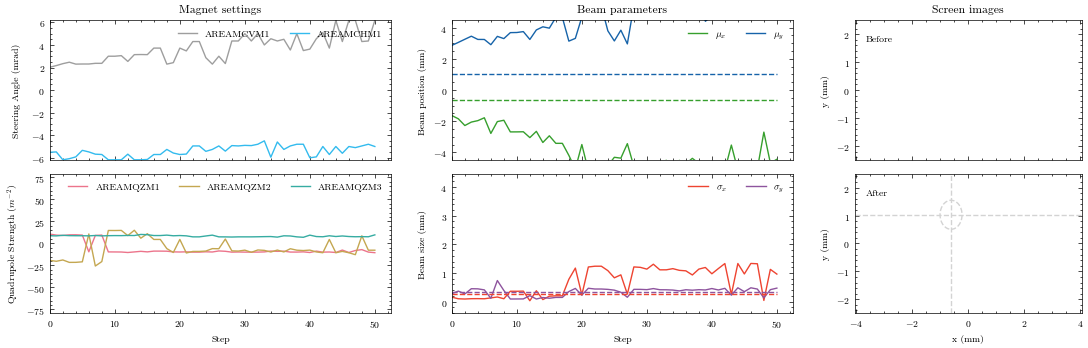

In [24]:
_ = episode.plot_summary()

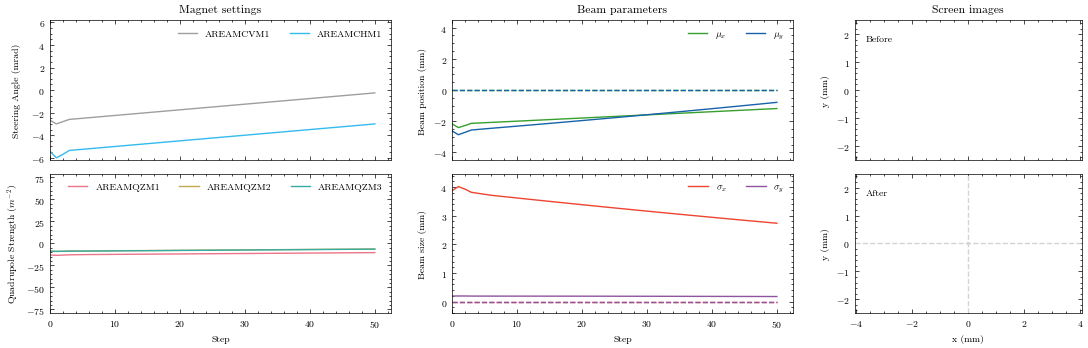

In [23]:
_ = episode.plot_summary()  # GPT 4 Turbo preview (optimisation setup)

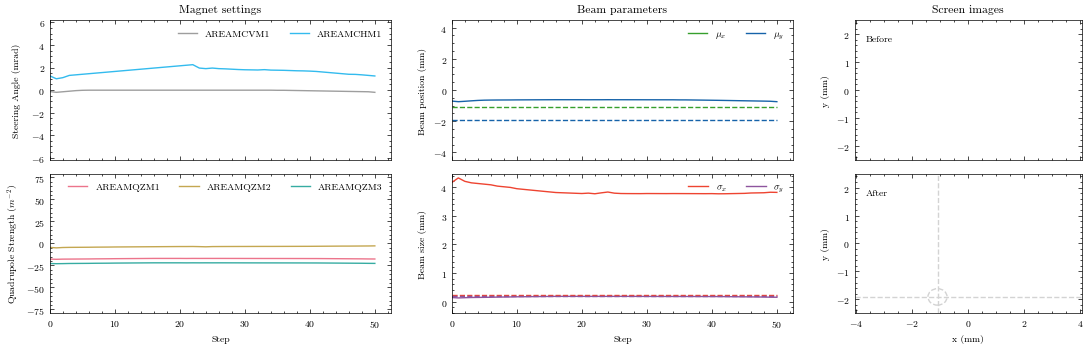

In [23]:
_ = episode.plot_summary()  # GPT 4 (optimisation setup / other trial)

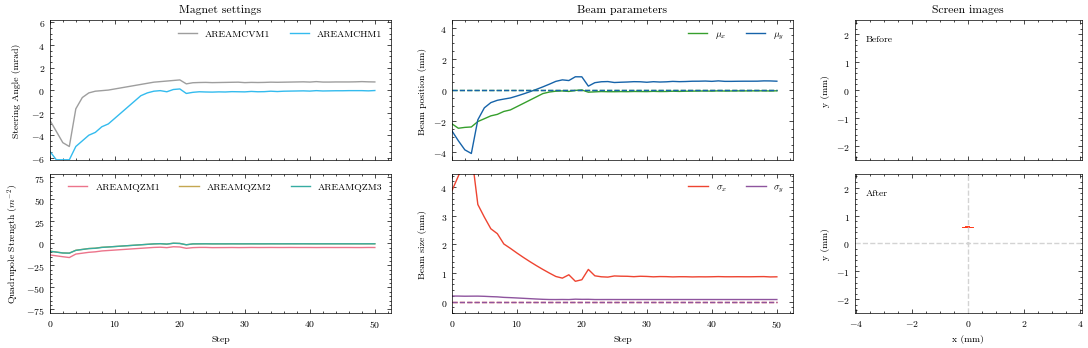

In [23]:
_ = episode.plot_summary()  # GPT 4 (optimisation setup)

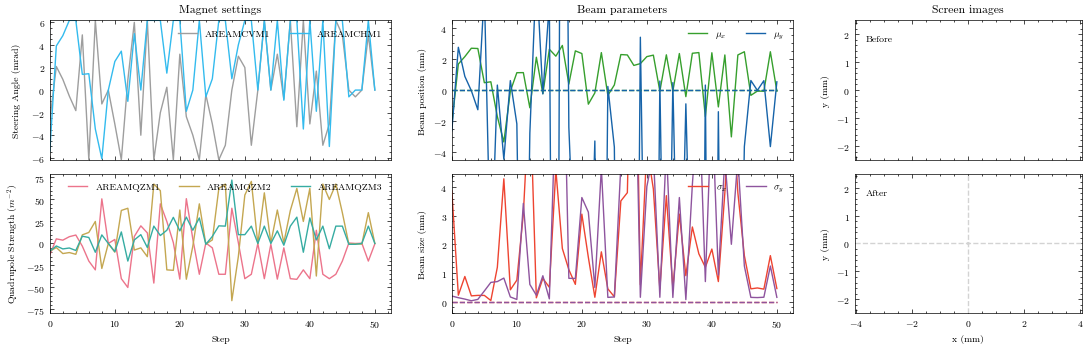

In [23]:
_ = episode.plot_summary()  # Starling (optimisation setup)

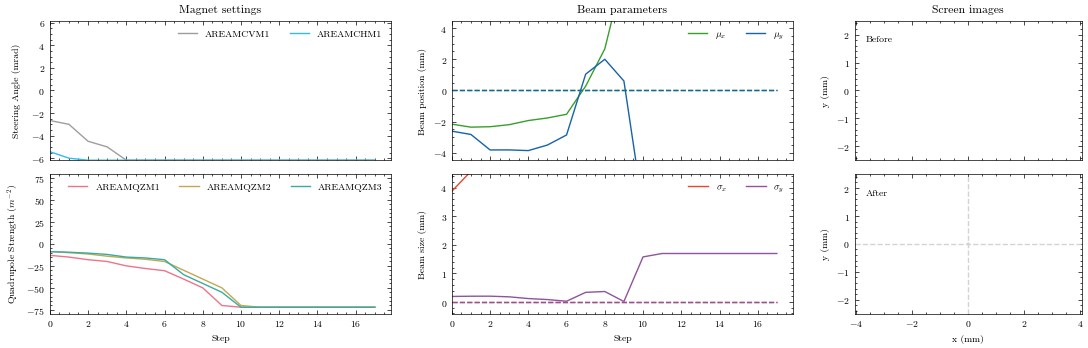

In [23]:
_ = episode.plot_summary()  # Mistral (optimisation setup)

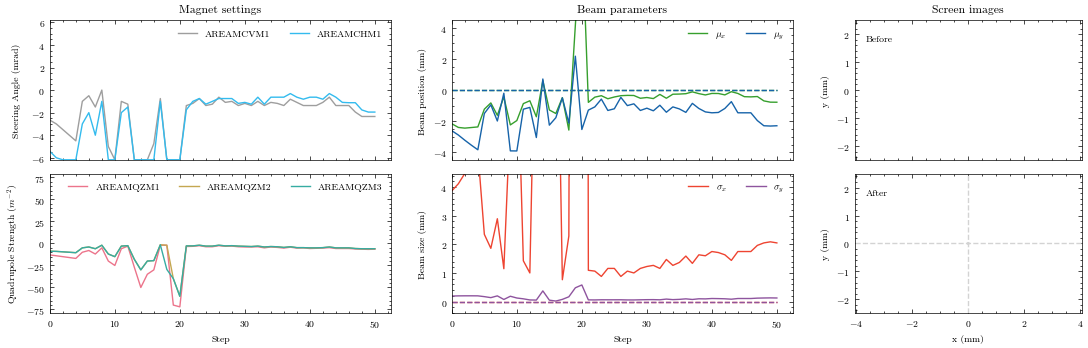

In [23]:
_ = episode.plot_summary()  # Mixtral (optimisation setup unordered)

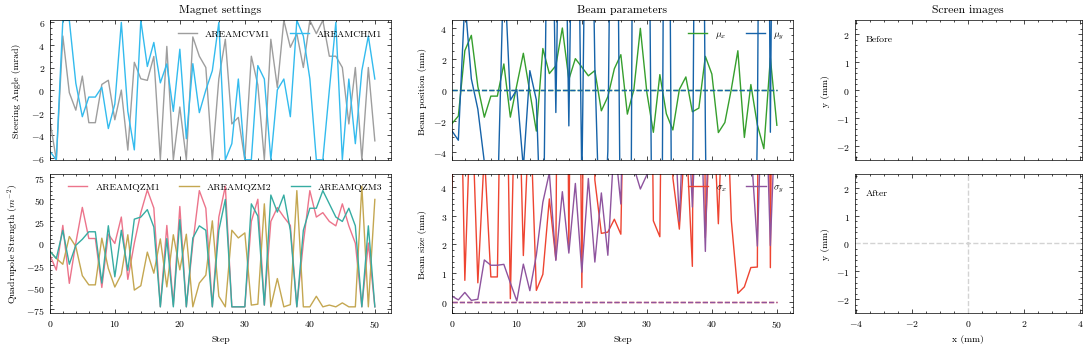

In [23]:
_ = episode.plot_summary()  # Starling (optimisation setup / unsorted)

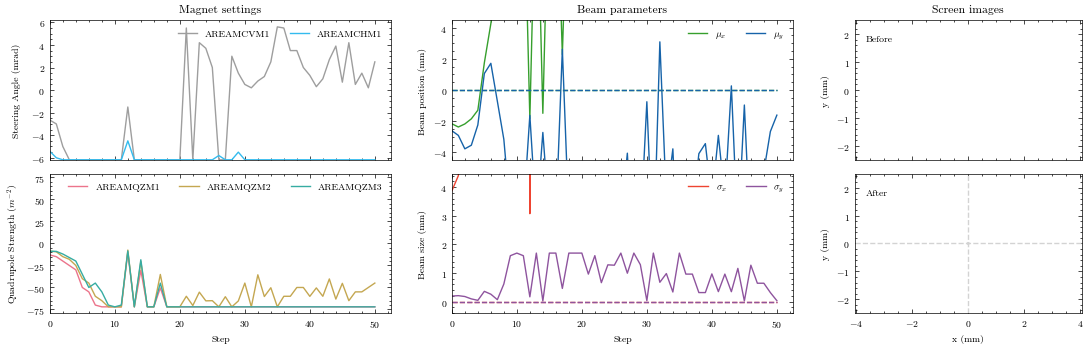

In [23]:
_ = episode.plot_summary()  # Mistral (optimisation setup / unsorted)

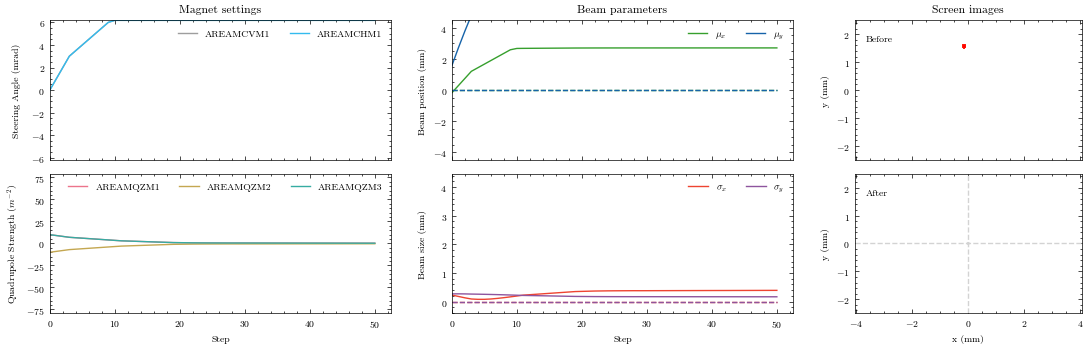

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting from FDF)

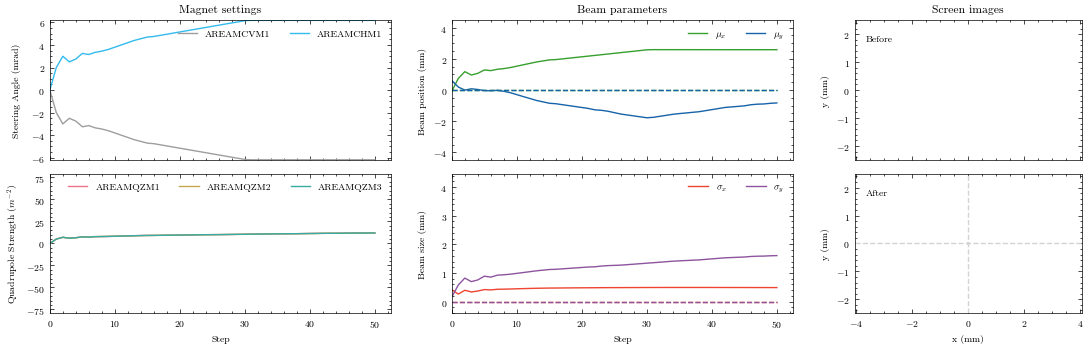

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting magnets from zero)

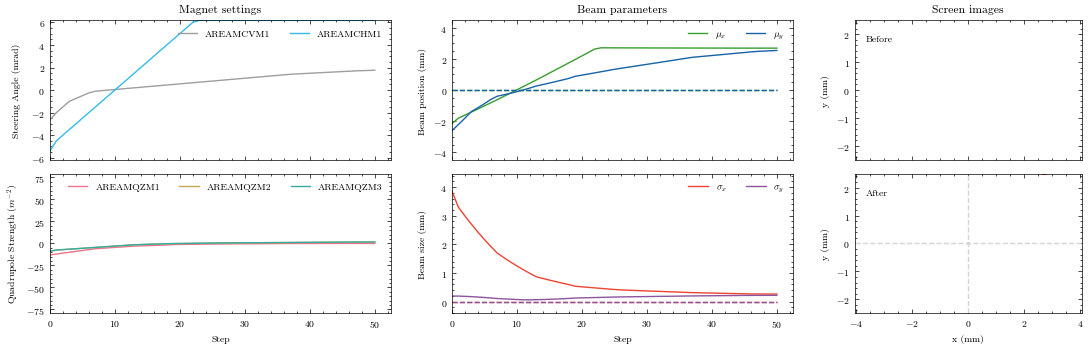

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set any magnet to zero)

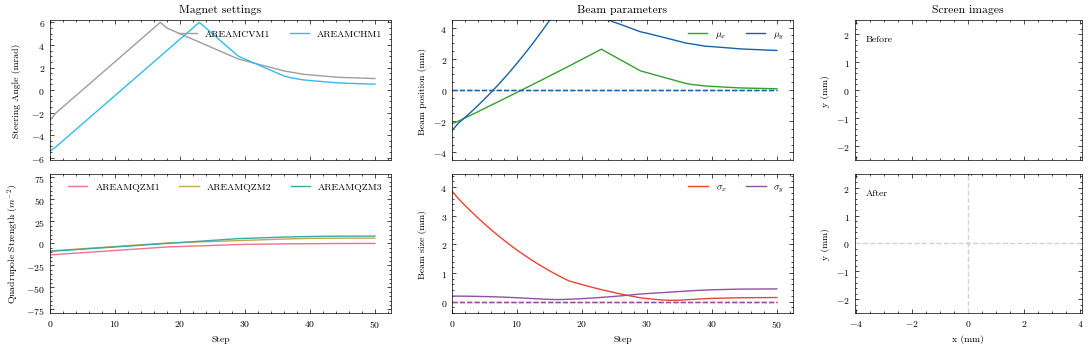

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set all magnets to zero)

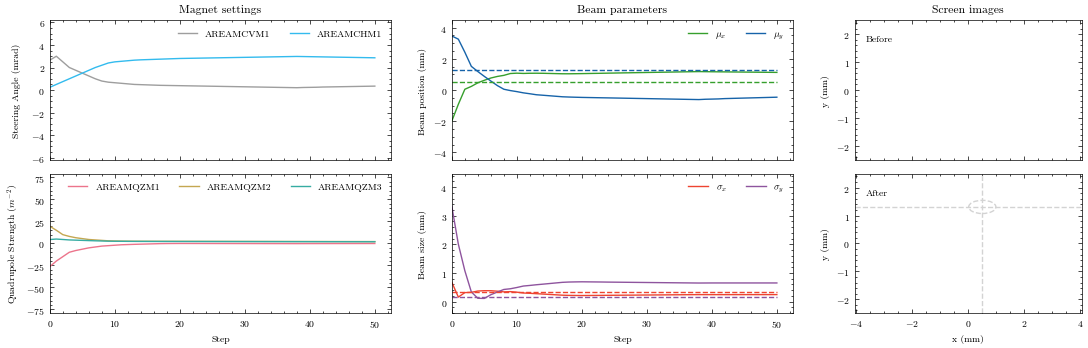

In [23]:
_ = episode.plot_summary()  # GPT-4 (Target beam different index 32)

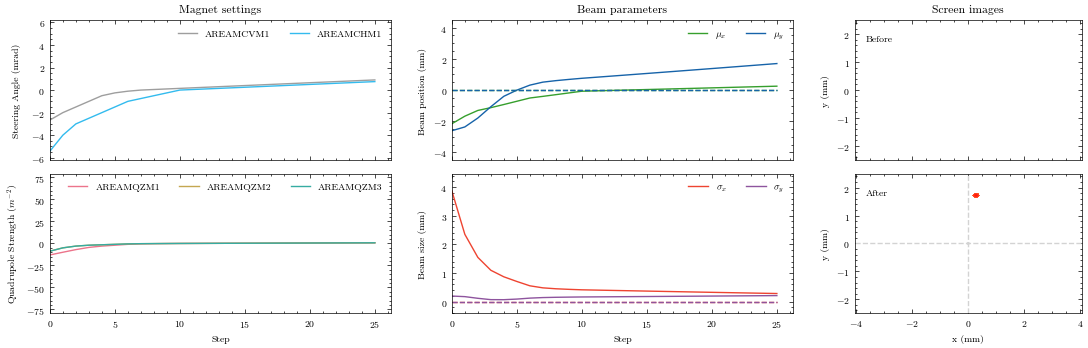

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (target in prompt + smooth)

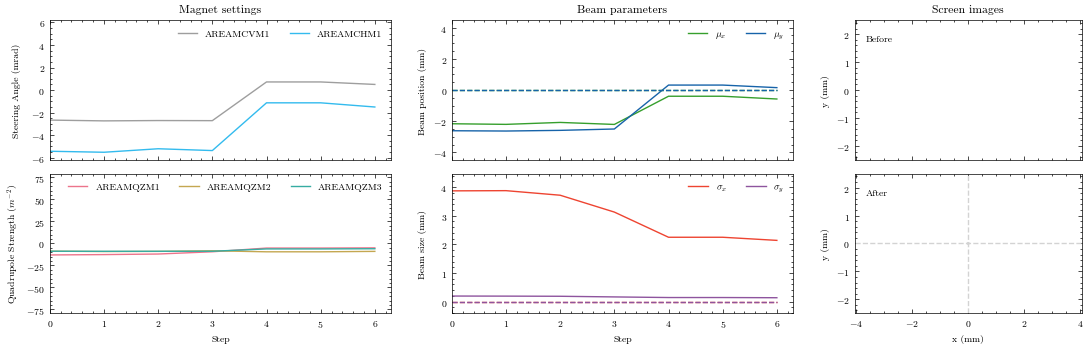

In [23]:
_ = episode.plot_summary()  # Megadolphin 120b

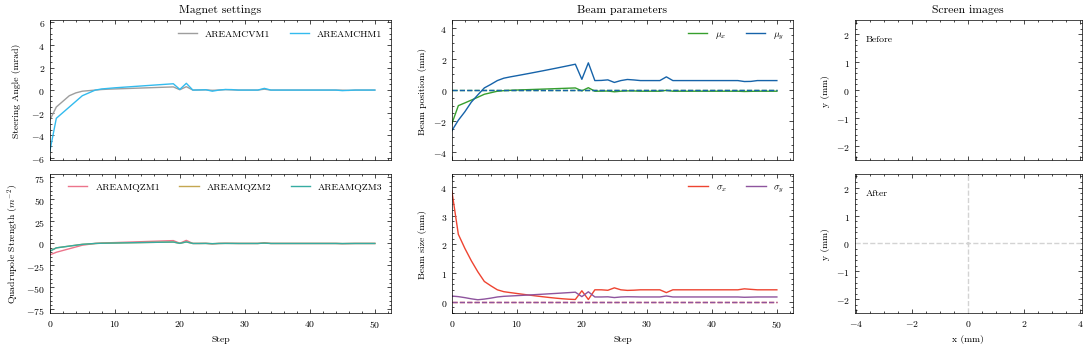

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (no units in history)

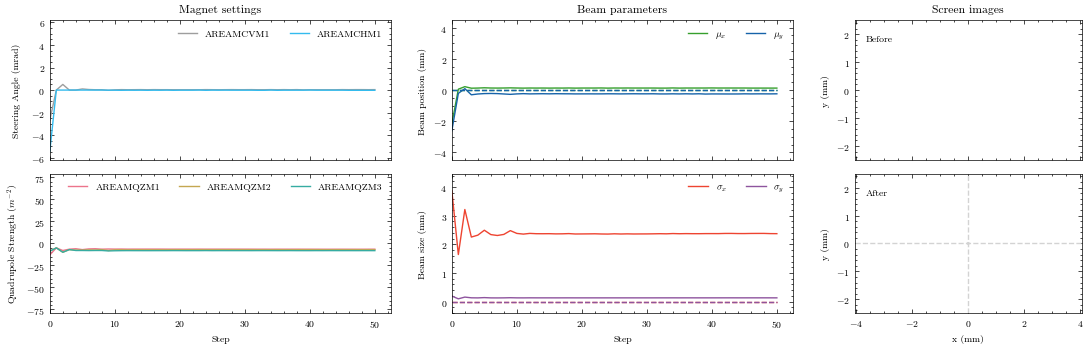

In [23]:
_ = episode.plot_summary()  # Mixtral Instruct (no units in history)

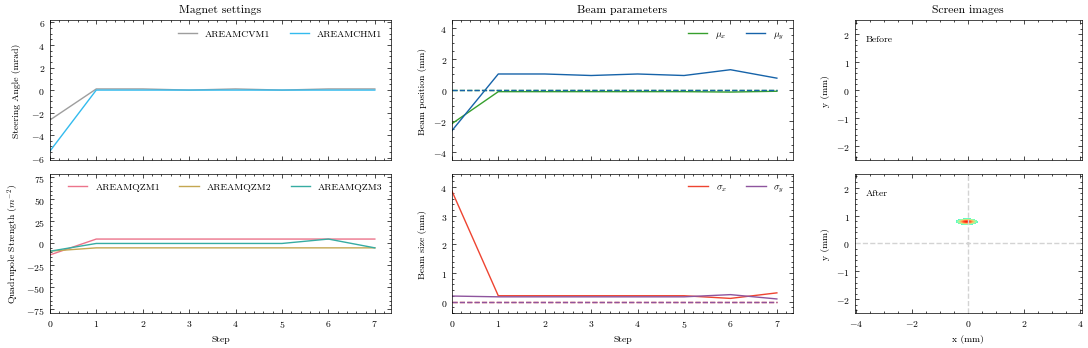

In [28]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

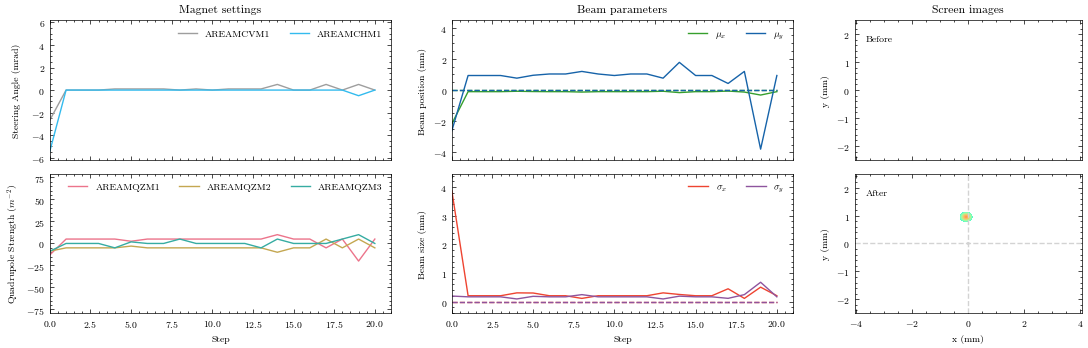

In [29]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

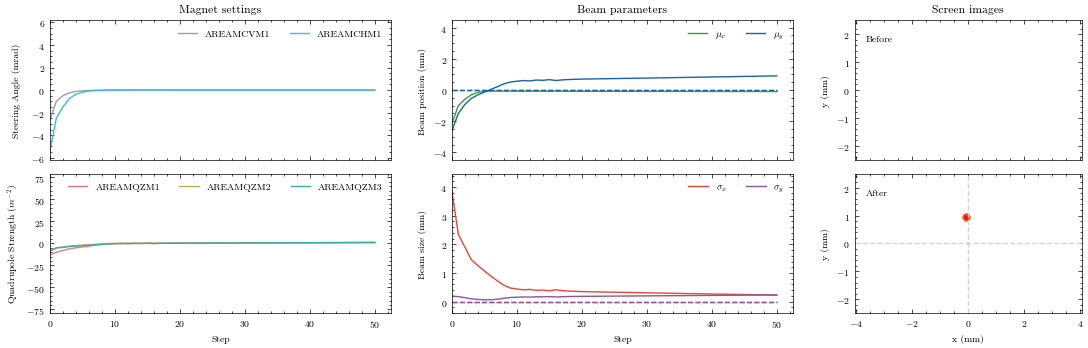

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

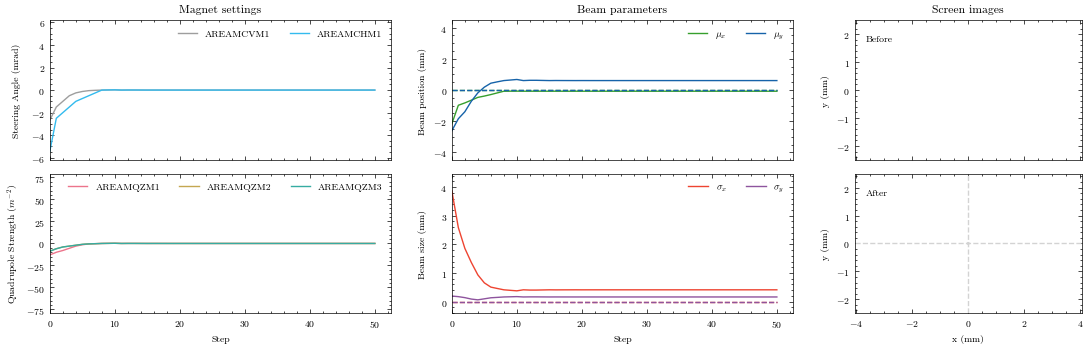

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

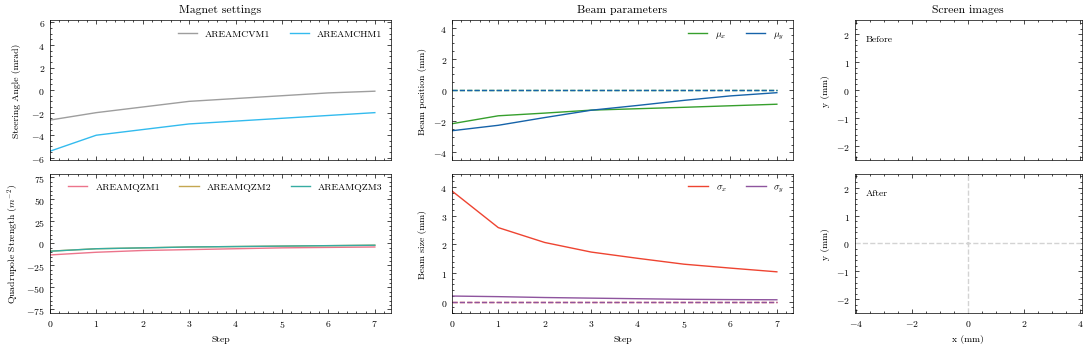

In [26]:
_ = episode.plot_summary()  # GPT-4

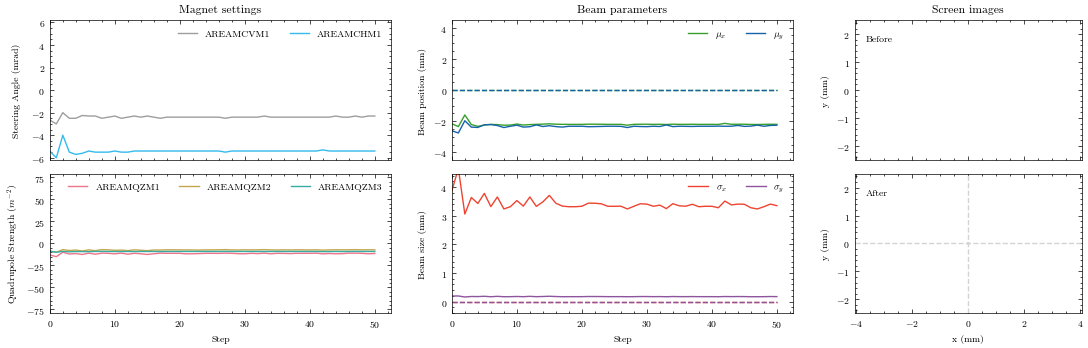

In [26]:
_ = episode.plot_summary()  # GPT-3.5-turbo-1106

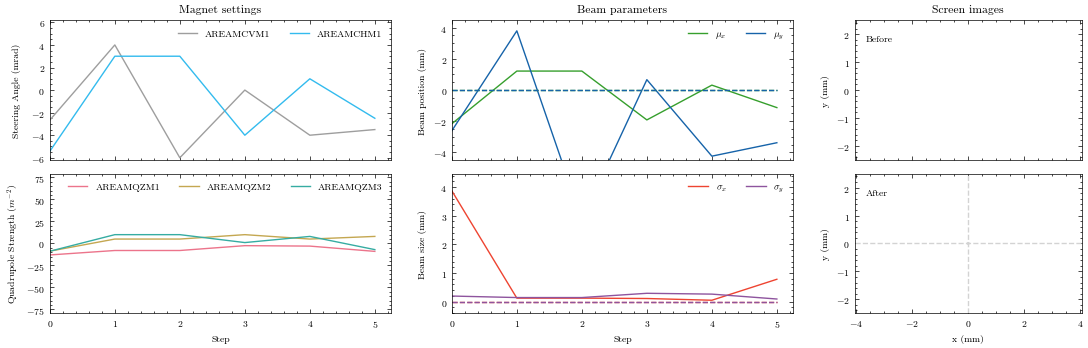

In [26]:
_ = episode.plot_summary()  # mistral-openorca

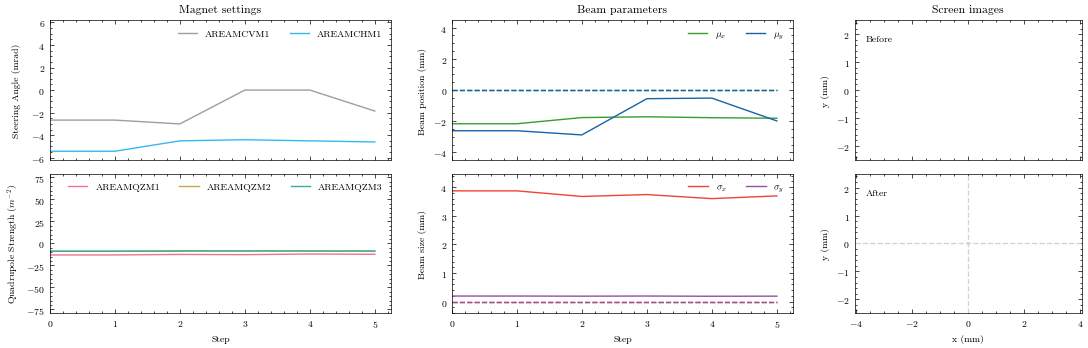

In [26]:
_ = episode.plot_summary()  # Llama2 7B-Chat

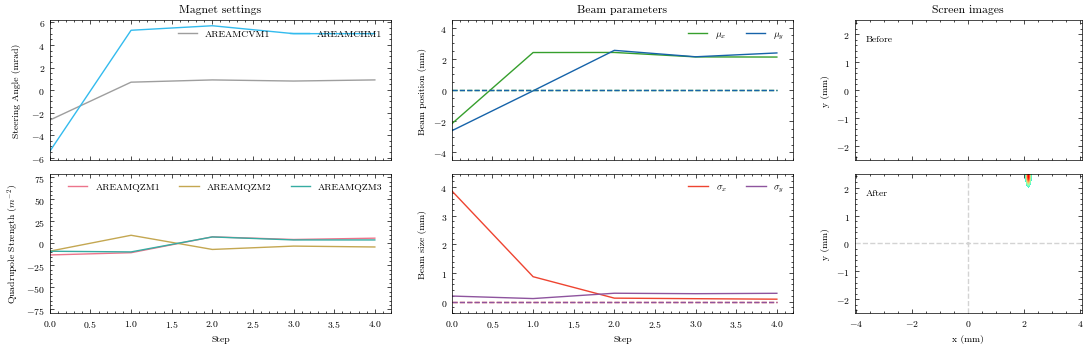

In [26]:
_ = episode.plot_summary()  # Mistral 7B Instruct

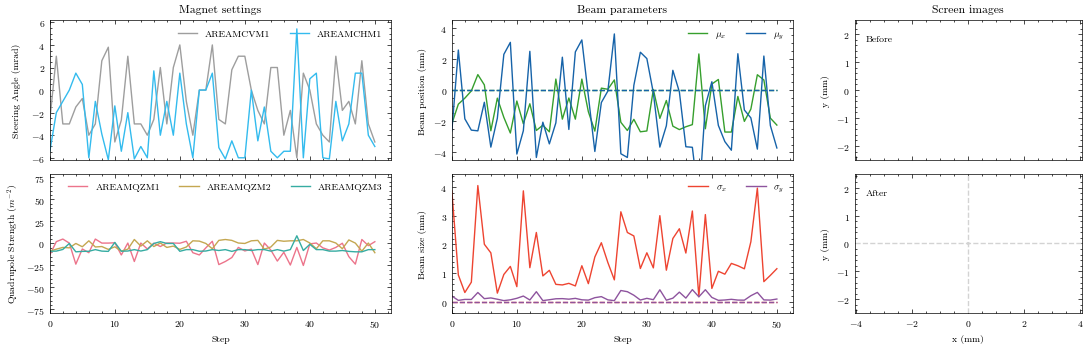

In [26]:
_ = episode.plot_summary()  # Vicuna 7B 16K

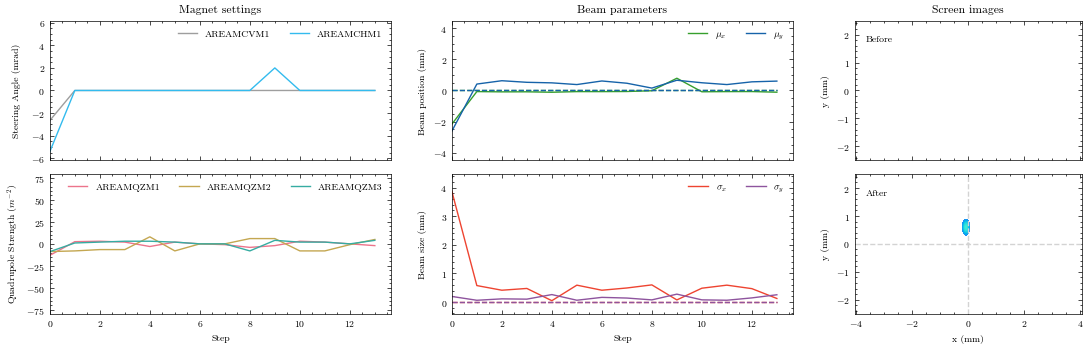

In [24]:
_ = episode.plot_summary()  # Starling

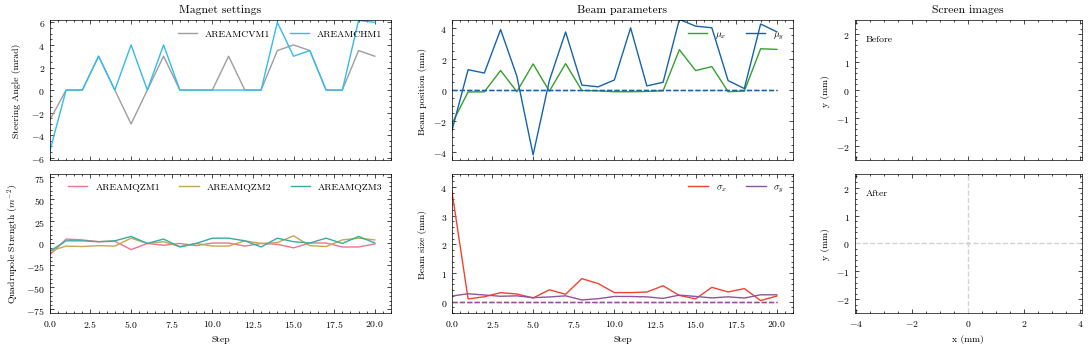

In [24]:
_ = episode.plot_summary()  # Starling

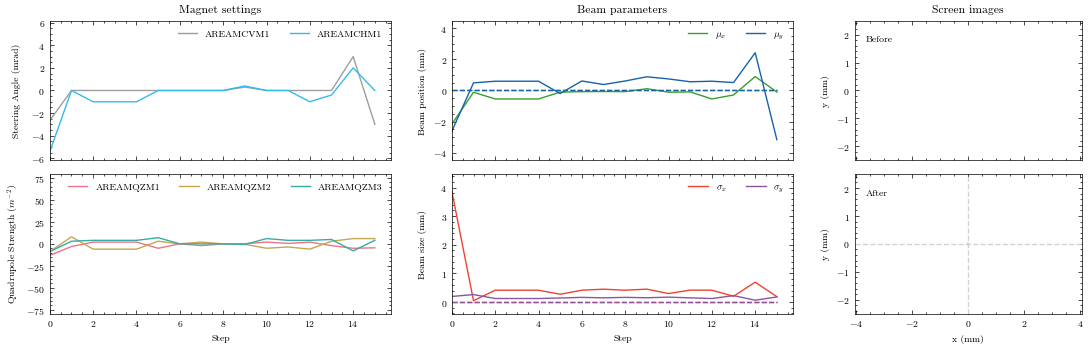

In [27]:
_ = episode.plot_summary()  # Starling

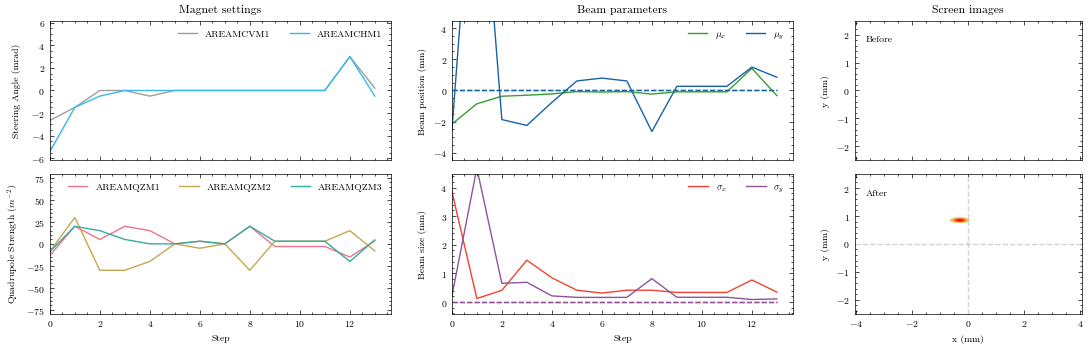

In [24]:
_ = episode.plot_summary()  # Starling

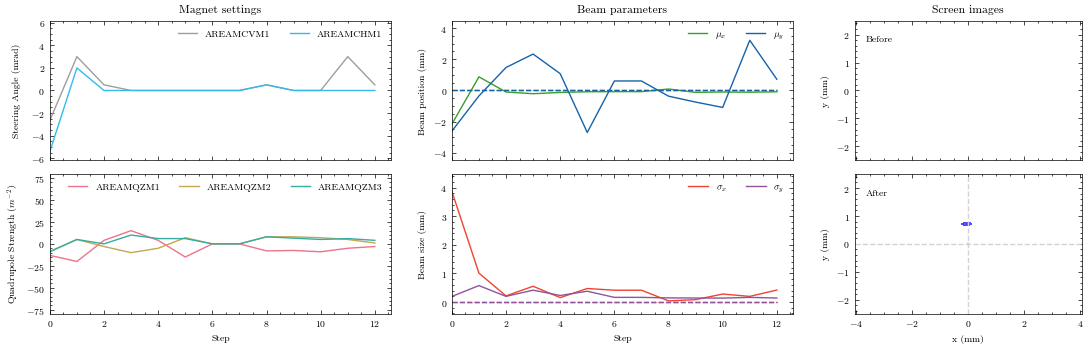

In [24]:
_ = episode.plot_summary()  # Starling

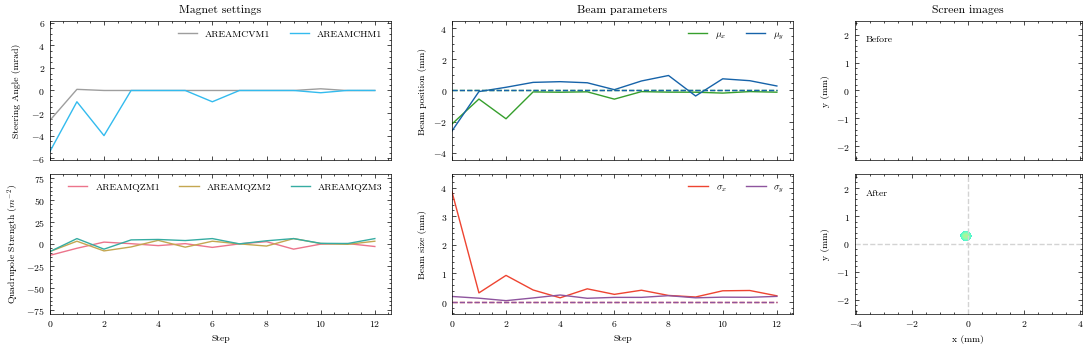

In [24]:
_ = episode.plot_summary()  # Starling

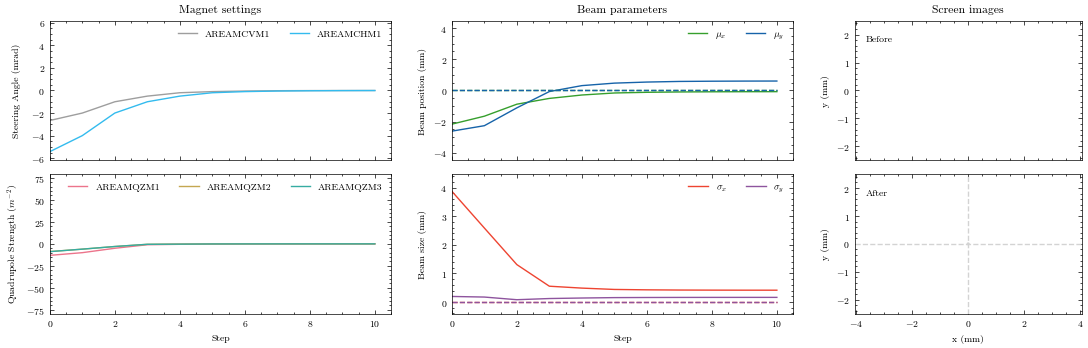

In [24]:
_ = episode.plot_summary()

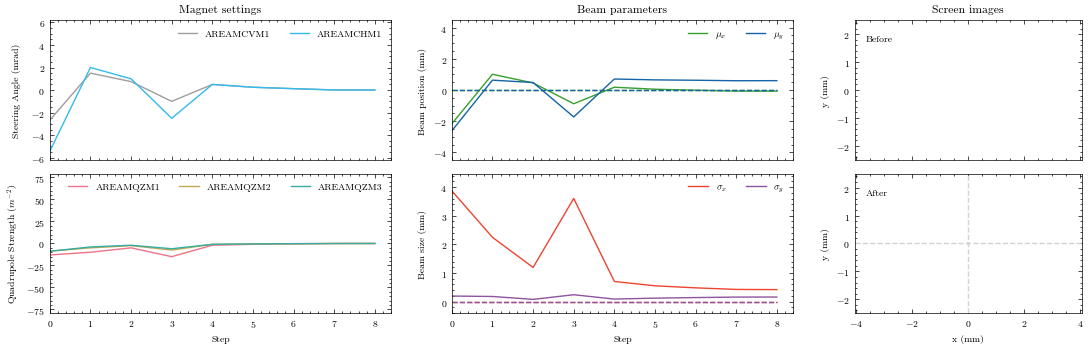

In [23]:
_ = episode.plot_summary()

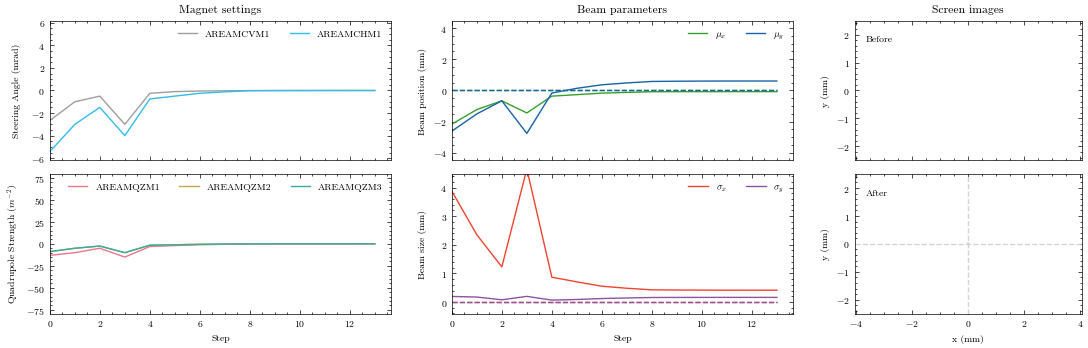

In [23]:
_ = episode.plot_summary()

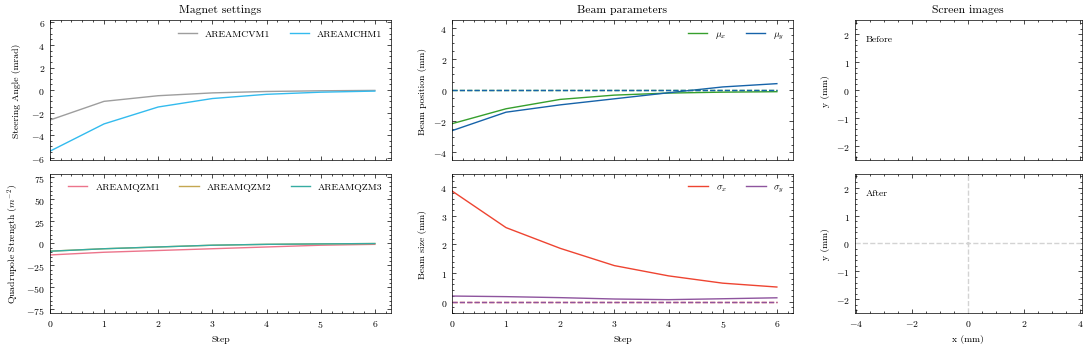

In [23]:
_ = episode.plot_summary()

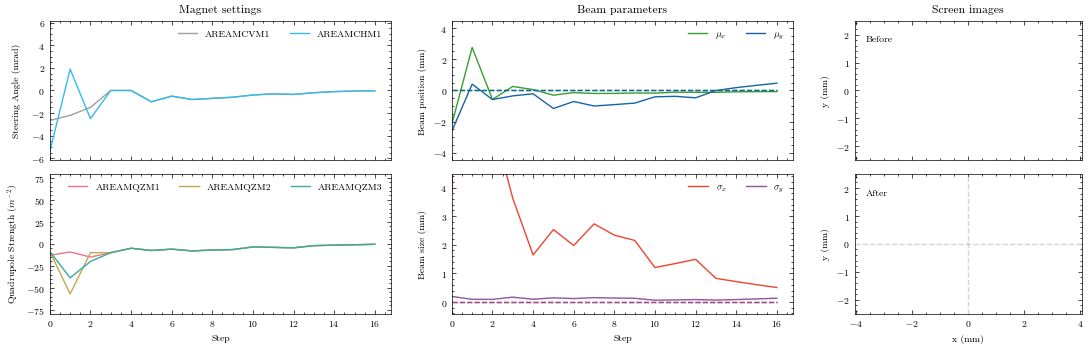

In [23]:
_ = episode.plot_summary()

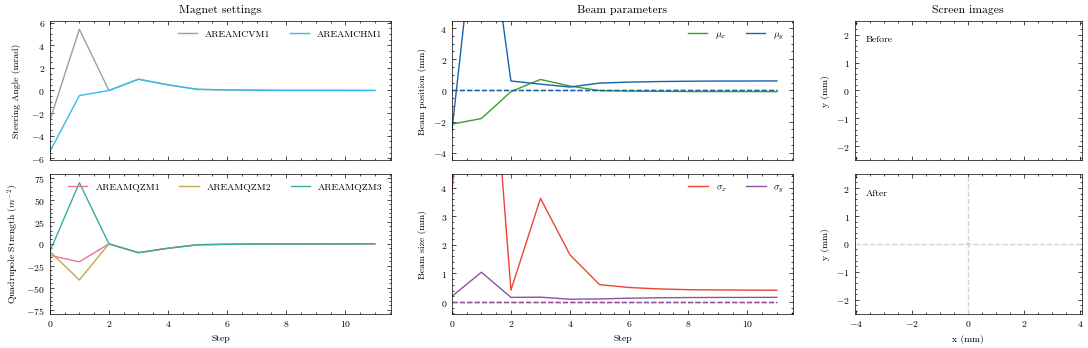

In [28]:
_ = episode.plot_summary()

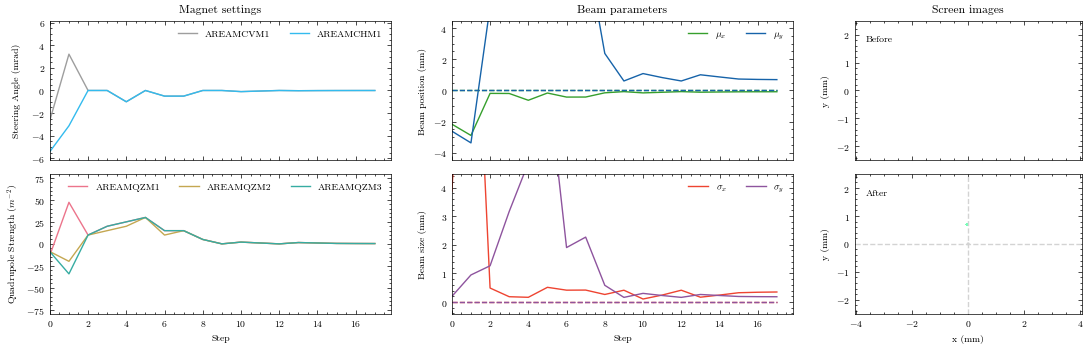

In [23]:
_ = episode.plot_summary()

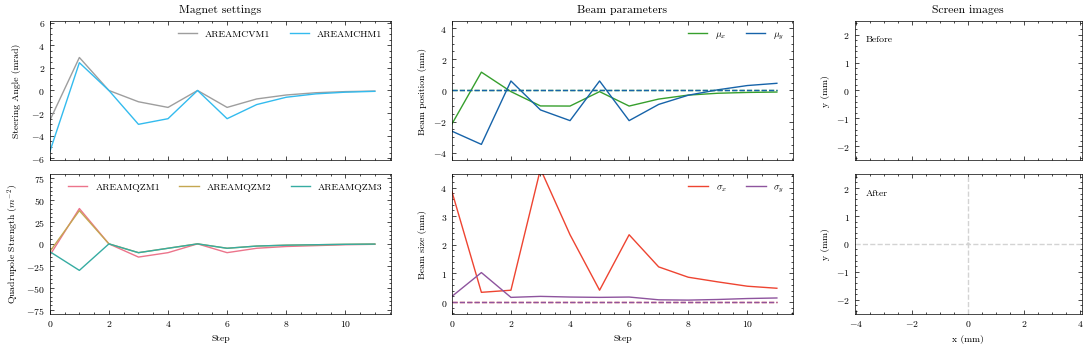

In [23]:
_ = episode.plot_summary()

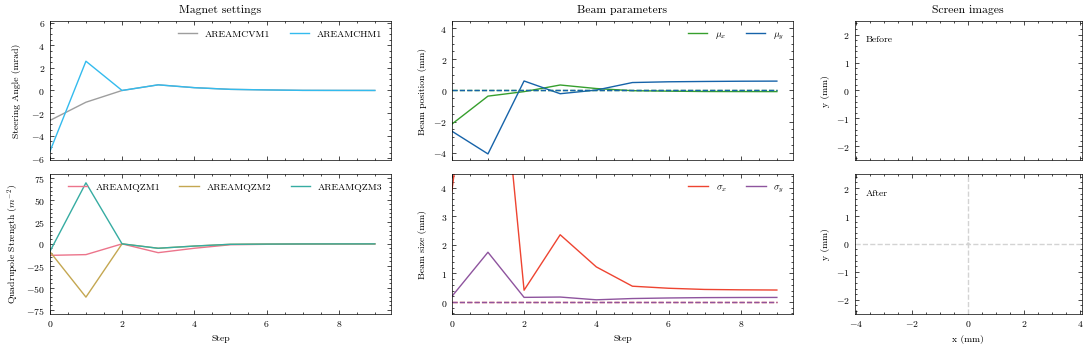

In [23]:
_ = episode.plot_summary()

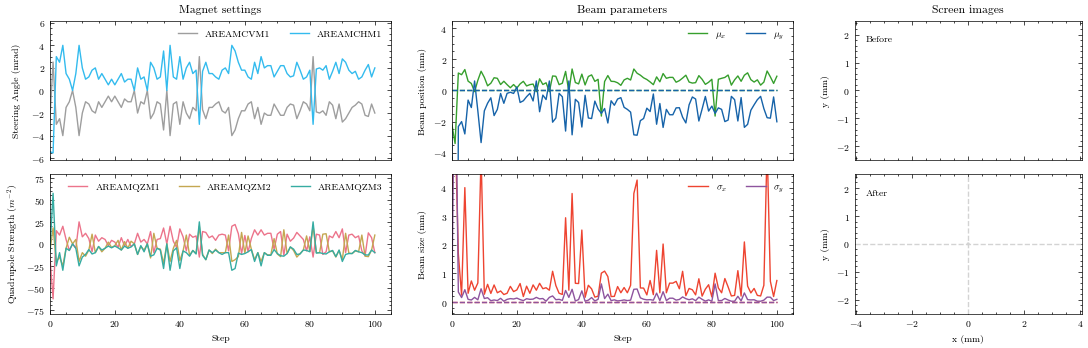

In [23]:
_ = episode.plot_summary()

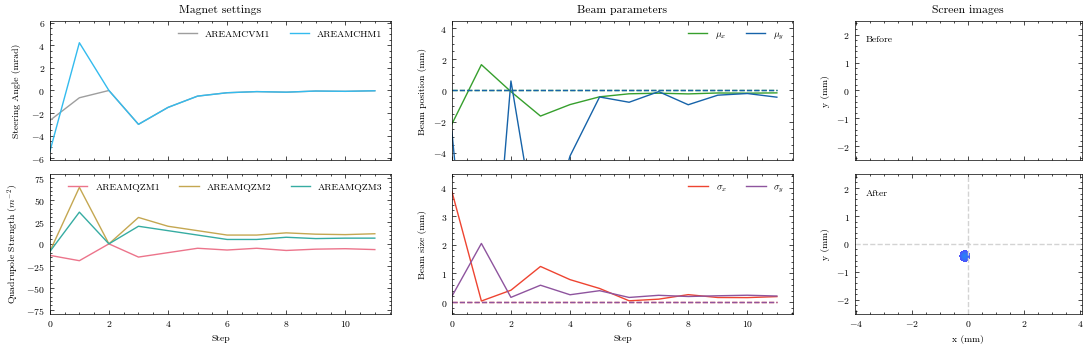

In [67]:
_ = episode.plot_summary()